In [3]:
from __future__ import division, print_function, absolute_import
import logging
import tensorflow as tf
import os
tf.logging.set_verbosity(tf.logging.ERROR)
import numpy as np
from config import pathDict
from conv_net.train import Train
from conv_net.test import Test
from data_transformation.data_prep import get_valid_land_house_ids, dumpStratifiedBatches_balanced_class
from plot import Plot
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")


images_per_label = None # normally 5000 each label is good
assessor_img_type = 'assessor'
aerial_img_type = 'google_aerial' # 'bing_aerial'
overlayed_img_type = 'google_overlayed'
streetside_img_type = None
image_type = assessor_img_type

if image_type == 'assessor':
    inp_image_shape = [260, 260, 3]
    
    
which_net = 'resnet'
batch_prepare = True
train = True
test = True

## PREPARE/DUMP BATCHES:

In [5]:
if batch_prepare:
    cmn_land_pins, cmn_house_pins = get_valid_land_house_ids(
            aerial_img_type=aerial_img_type,
            streetside_img_type=streetside_img_type,
            overlayed_img_type=overlayed_img_type,
            images_per_label=images_per_label)
    print (len(cmn_land_pins), len(cmn_house_pins))

    tr_batch_size = 128
    ts_batch_size = (len(cmn_land_pins) + len(cmn_house_pins)) // 10
    cv_batch_size = (len(cmn_land_pins) + len(cmn_house_pins)) // 10
    
    dumpStratifiedBatches_balanced_class(cmn_land_pins, cmn_house_pins, img_resize_shape=inp_image_shape,
                                         image_type=image_type, ts_batch_size=ts_batch_size, 
                                         cv_batch_size=cv_batch_size, tr_batch_size=tr_batch_size,
                                         shuffle_seed=873, get_stats=True, max_batches=None)

/Users/sam/All-Program/App-DataSet/HouseClassification/input_images/aerial_images/google/land
aerial pins:  17435 20707
common aerial pins:  16012 16793
/Users/sam/All-Program/App-DataSet/HouseClassification/input_images/overlayed_images/google/land
overlayed pins:  5612 9519
common overlayed pins:  5433 8674
5433 5433


# EVALUATE MODELS:
------------

# TRAIN MODEL: Assessor Images 
------------

## Train  learning_rate = 0.0001
-----------

In [2]:
max_batches = 66
if train:
    tr_obj = Train(dict(inp_img_shape=[400,400,3],
                   crop_shape=[96,96,3],
                   out_img_shape=[224, 224, 3],
                   use_checkpoint=True,
                   save_checkpoint=True,
                   write_tensorboard_summary=False
                   ),
              which_net=which_net,  # vgg
              image_type=image_type)
    (tr_loss_arr, tr_acc_arr, tr_precision_arr, tr_recall_arr, 
     cv_loss_arr, cv_acc_arr, cv_precision_arr, cv_recall_arr,
     l_rate_arr)  = tr_obj.run(num_epochs=3, num_batches=max_batches, get_stats_at=10)# + 1)

Dumping Checkpoints to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/checkpoint/resnet
Dumping Tensorboard Summary to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/summary/resnet
Checkpoints not found, Hence starting at batch 0 and epoch 0........


In [3]:
print ('Mean Values: train_loss = %s, train_acc = %s, train_precision = %s, train_recall = %s, cv_loss = %s, cv_acc = %s, cv_precision = %s, cv_recall = %s'%(
    np.mean(tr_loss_arr), np.mean(tr_acc_arr), np.mean(tr_precision_arr), np.mean(tr_recall_arr), np.mean(cv_loss_arr), np.mean(cv_acc_arr), np.mean(cv_precision_arr), np.mean(cv_recall_arr)))

Mean Values: train_loss = 2.90343, train_acc = 0.866855, train_precision = 0.877154040752, train_recall = 0.867529097399, cv_loss = 3.13067, cv_acc = 0.856748, cv_precision = 0.859740415177, cv_recall = 0.858984477769


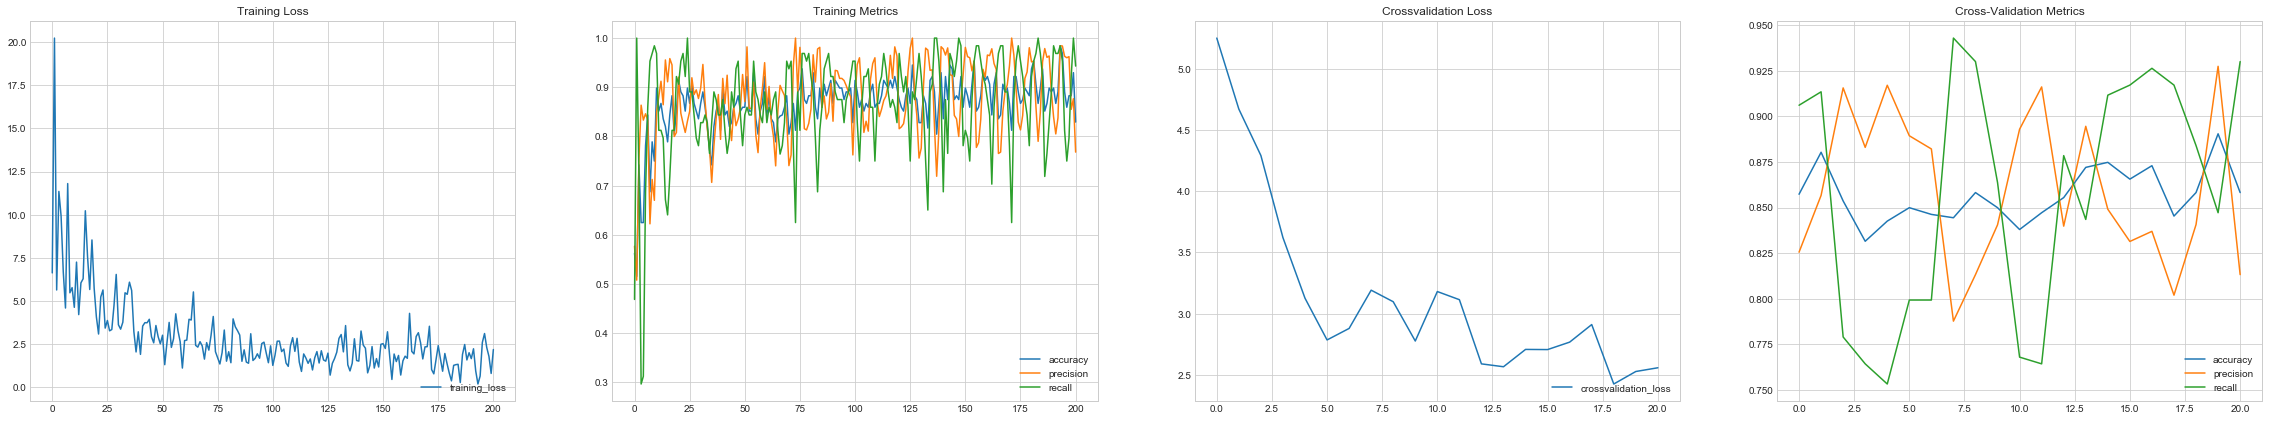

In [5]:
oj = Plot(rows=1, columns=4, fig_size=(40,7))
tr_loss_df = pd.DataFrame(tr_loss_arr, columns=['training_loss'])
oj.vizualize(data=tr_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Loss'})
tr_data = pd.DataFrame(np.column_stack((tr_acc_arr, tr_precision_arr, tr_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=tr_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Metrics'})

cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})
cv_data = pd.DataFrame(np.column_stack((cv_acc_arr, cv_precision_arr, cv_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=cv_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Cross-Validation Metrics'})

### Cross Validation and Test : learning_rate = 0.0001

In [ ]:
which_data = 'cvalid'
if test:
    tsoj = Test(params=dict(inp_img_shape=[400,400,3],
                     crop_shape=[96, 96, 3],
                     out_img_shape=[224, 224, 3]),
         which_net=which_net,
         image_type=image_type)
    cv_loss_arr, cv_acc_arr, cv_precision_arr, cv_recall_arr = tsoj.run(which_data=which_data, dump_stats=True)

In [4]:
which_data = 'test'
if test:
    tsoj = Test(params=dict(inp_img_shape=[400,400,3],
                     crop_shape=[96, 96, 3],
                     out_img_shape=[224, 224, 3]),
         which_net=which_net,
         image_type=image_type)
    ts_loss_arr, ts_acc_arr, ts_precision_arr, ts_recall_arr = tsoj.run(which_data=which_data, dump_stats=True)

Dumping Checkpoints to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/checkpoint/resnet
Dumping Tensorboard Summary to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/summary/resnet
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET


In [5]:
print ('Mean Values: cvalid_loss = %s, cvalid_acc = %s, cvalid_precision = %s, cvalid_recall = %s, test_loss = %s, test_acc = %s, test_precision = %s, test_recall = %s'%(
    np.mean(cv_loss_arr), np.mean(cv_acc_arr), np.mean(cv_precision_arr), np.mean(cv_recall_arr), np.mean(ts_loss_arr), np.mean(ts_acc_arr), np.mean(ts_precision_arr), np.mean(ts_recall_arr)))

Mean Values: cvalid_loss = 2.68768, cvalid_acc = 0.863996, cvalid_precision = 0.855100215883, cvalid_recall = 0.881952117864, test_loss = 2.56214, test_acc = 0.865286, test_precision = 0.858191571786, test_recall = 0.880110497238


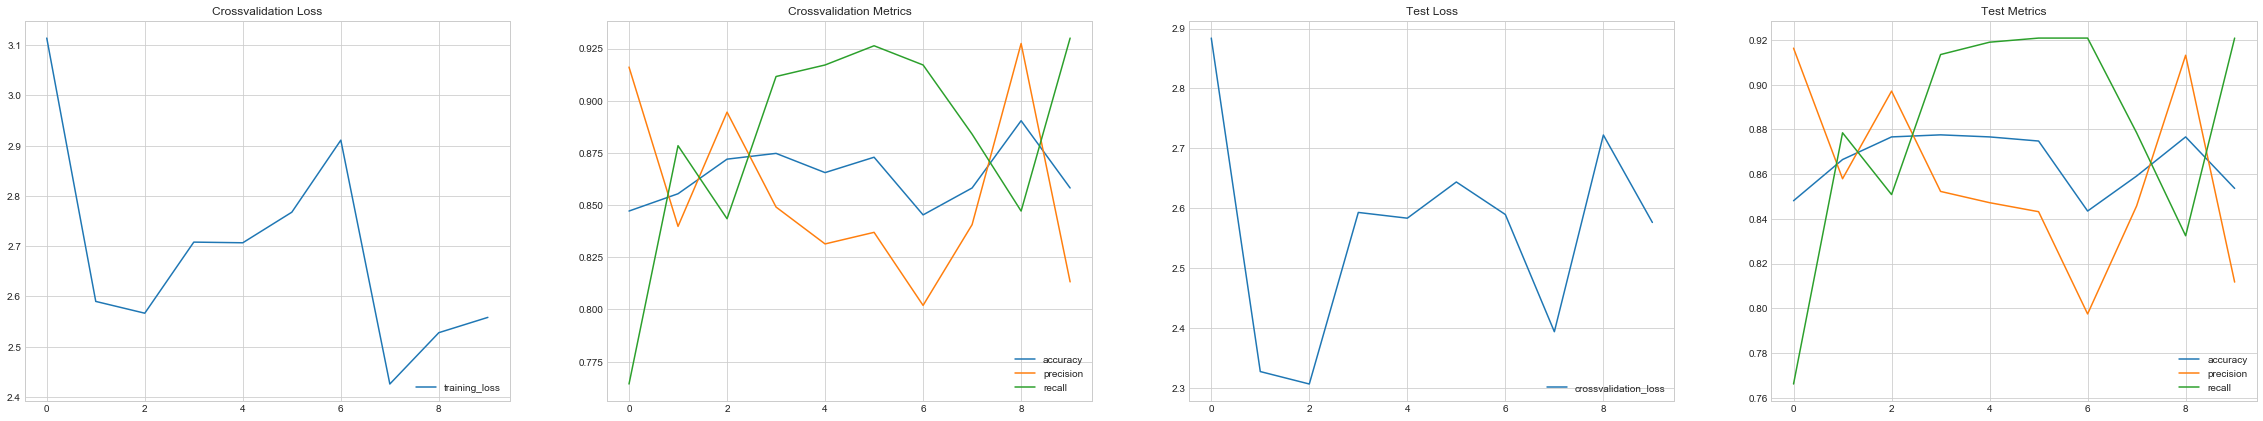

In [9]:
oj = Plot(rows=1, columns=4, fig_size=(40,7))
cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['training_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})
cv_data = pd.DataFrame(np.column_stack((cv_acc_arr, cv_precision_arr, cv_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=cv_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Metrics'})

ts_loss_df = pd.DataFrame(ts_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=ts_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Test Loss'})
ts_data = pd.DataFrame(np.column_stack((ts_acc_arr, ts_precision_arr, ts_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=ts_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Test Metrics'})

## Train: Learning Rate 0.0005
----------

In [2]:
max_batches = 66
if train:
    tr_obj = Train(dict(inp_img_shape=[400,400,3],
                   crop_shape=[96,96,3],
                   out_img_shape=[224, 224, 3],
                   use_checkpoint=True,
                   save_checkpoint=True,
                   write_tensorboard_summary=False
                   ),
              which_net=which_net,  # vgg
              image_type=image_type)
    tr_loss_arr, tr_acc_arr, tr_precision_arr, tr_recall_arr, cv_loss_arr, cv_acc_arr, cv_precision_arr, cv_recall_arr = tr_obj.run(num_epochs=3, num_batches=max_batches, get_stats_at=10)# + 1)

Dumping Checkpoints to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/checkpoint/resnet
Dumping Tensorboard Summary to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/summary/resnet
Learning Rate: Initial:  0.0005
Checkpoints not found, Hence starting at batch 0 and epoch 0........


In [3]:
print ('Mean Values: train_loss = %s, train_acc = %s, train_precision = %s, train_recall = %s, cv_loss = %s, cv_acc = %s, cv_precision = %s, cv_recall = %s'%(
    np.mean(tr_loss_arr), np.mean(tr_acc_arr), np.mean(tr_precision_arr), np.mean(tr_recall_arr), np.mean(cv_loss_arr), np.mean(cv_acc_arr), np.mean(cv_precision_arr), np.mean(cv_recall_arr)))

Mean Values: train_loss = 4.486, train_acc = 0.863069, train_precision = 0.875937975391, train_recall = 0.863384424423, cv_loss = 3.18716, cv_acc = 0.874156, cv_precision = 0.882285222982, cv_recall = 0.87126194861


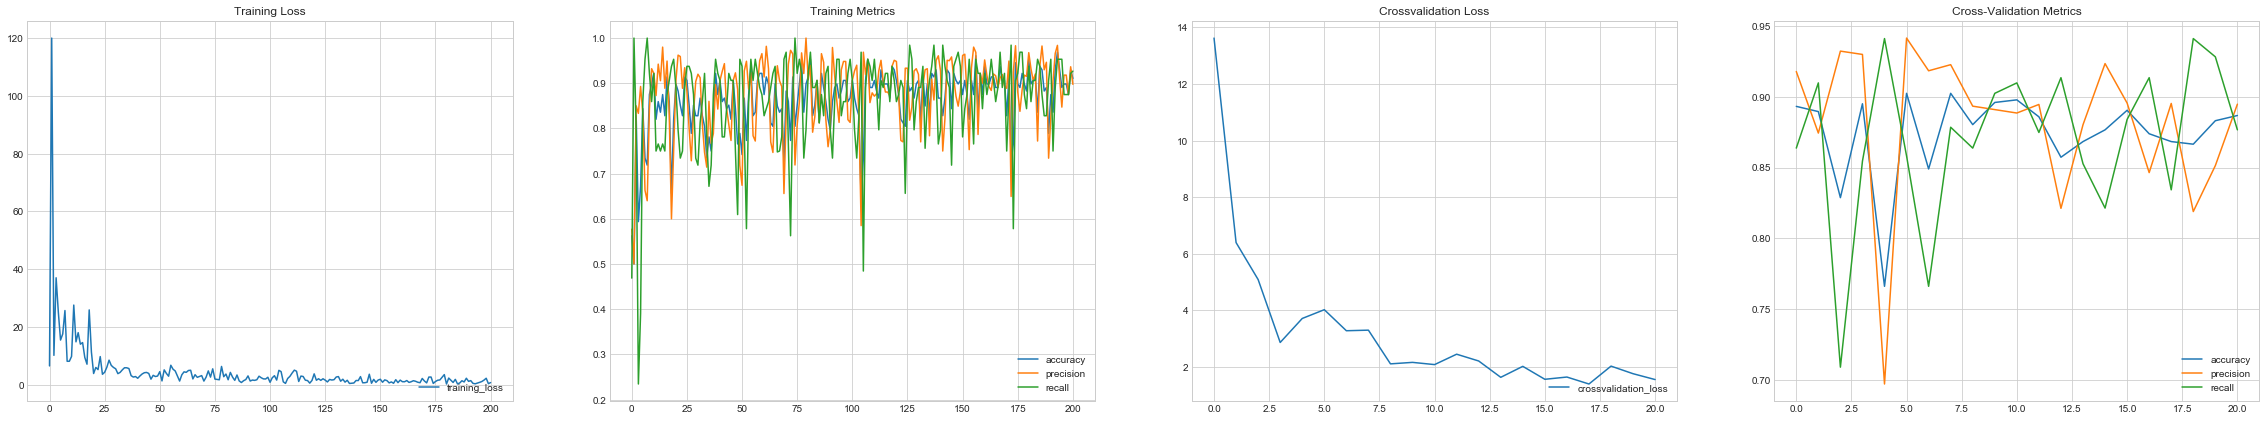

In [4]:
oj = Plot(rows=1, columns=4, fig_size=(40,7))
tr_loss_df = pd.DataFrame(tr_loss_arr, columns=['training_loss'])
oj.vizualize(data=tr_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Loss'})
tr_data = pd.DataFrame(np.column_stack((tr_acc_arr, tr_precision_arr, tr_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=tr_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Metrics'})

cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})
cv_data = pd.DataFrame(np.column_stack((cv_acc_arr, cv_precision_arr, cv_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=cv_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Cross-Validation Metrics'})

### Corssvalidation and Test: Learning rate = 0.0005

In [6]:
which_data = 'cvalid'
if test:
    tsoj = Test(params=dict(inp_img_shape=[400,400,3],
                     crop_shape=[96, 96, 3],
                     out_img_shape=[224, 224, 3]),
         which_net=which_net,
         image_type=image_type)
    cv_loss_arr, cv_acc_arr, cv_precision_arr, cv_recall_arr = tsoj.run(which_data=which_data, dump_stats=True)

Dumping Checkpoints to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/checkpoint/resnet
Dumping Tensorboard Summary to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/summary/resnet
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Test Graphs: RESNET
Learning Rate: Initial:  0.0005


In [7]:
which_data = 'test'
if test:
    tsoj = Test(params=dict(inp_img_shape=[400,400,3],
                     crop_shape=[96, 96, 3],
                     out_img_shape=[224, 224, 3]),
         which_net=which_net,
         image_type=image_type)
    ts_loss_arr, ts_acc_arr, ts_precision_arr, ts_recall_arr = tsoj.run(which_data=which_data, dump_stats=True)

Dumping Checkpoints to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/checkpoint/resnet
Dumping Tensorboard Summary to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/summary/resnet
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Test Graphs: RESNET
Learning Rate: Initial:  0.0005


In [8]:
print ('Mean Values: cvalid_loss = %s, cvalid_acc = %s, cvalid_precision = %s, cvalid_recall = %s, test_loss = %s, test_acc = %s, test_precision = %s, test_recall = %s'%(
    np.mean(cv_loss_arr), np.mean(cv_acc_arr), np.mean(cv_precision_arr), np.mean(cv_recall_arr), np.mean(ts_loss_arr), np.mean(ts_acc_arr), np.mean(ts_precision_arr), np.mean(ts_recall_arr)))

Mean Values: cvalid_loss = 1.82797, cvalid_acc = 0.875691, cvalid_precision = 0.872154837858, cvalid_recall = 0.883977900552, test_loss = 1.95437, test_acc = 0.875599, test_precision = 0.881211253432, test_recall = 0.872007366483


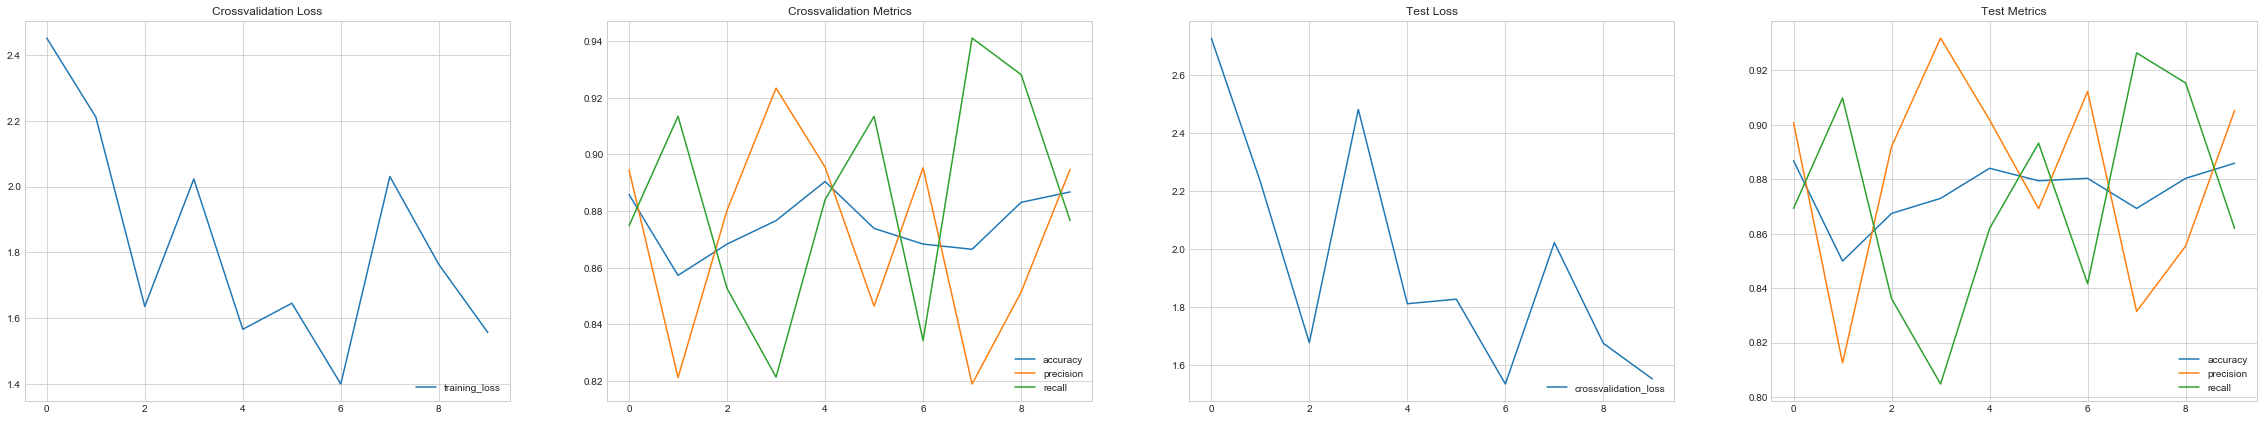

In [10]:
oj = Plot(rows=1, columns=4, fig_size=(40,7))
cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['training_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})
cv_data = pd.DataFrame(np.column_stack((cv_acc_arr, cv_precision_arr, cv_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=cv_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Metrics'})

ts_loss_df = pd.DataFrame(ts_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=ts_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Test Loss'})
ts_data = pd.DataFrame(np.column_stack((ts_acc_arr, ts_precision_arr, ts_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=ts_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Test Metrics'})

## TRAIN Learning Rate: 0.001

In [2]:
max_batches = 66
if train:
    tr_obj = Train(dict(inp_img_shape=[400,400,3],
                   crop_shape=[96,96,3],
                   out_img_shape=[224, 224, 3],
                   use_checkpoint=True,
                   save_checkpoint=True,
                   write_tensorboard_summary=False
                   ),
              which_net=which_net,  # vgg
              image_type=image_type)
    tr_loss_arr, tr_acc_arr, tr_precision_arr, tr_recall_arr, cv_loss_arr, cv_acc_arr, cv_precision_arr, cv_recall_arr = tr_obj.run(num_epochs=3, num_batches=max_batches, get_stats_at=10)# + 1)

Dumping Checkpoints to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/checkpoint/resnet
Dumping Tensorboard Summary to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/summary/resnet
Learning Rate: Initial:  0.001
Checkpoints not found, Hence starting at batch 0 and epoch 0........


In [3]:
print ('Mean Values: train_loss = %s, train_acc = %s, train_precision = %s, train_recall = %s, cv_loss = %s, cv_acc = %s, cv_precision = %s, cv_recall = %s'%(
    np.mean(tr_loss_arr), np.mean(tr_acc_arr), np.mean(tr_precision_arr), np.mean(tr_recall_arr), np.mean(cv_loss_arr), np.mean(cv_acc_arr), np.mean(cv_precision_arr), np.mean(cv_recall_arr)))

Mean Values: train_loss = 4.49772, train_acc = 0.85477, train_precision = 0.872019053238, train_recall = 0.85427726712, cv_loss = 2.7798, cv_acc = 0.87056, cv_precision = 0.88798176861, cv_recall = 0.857055160923


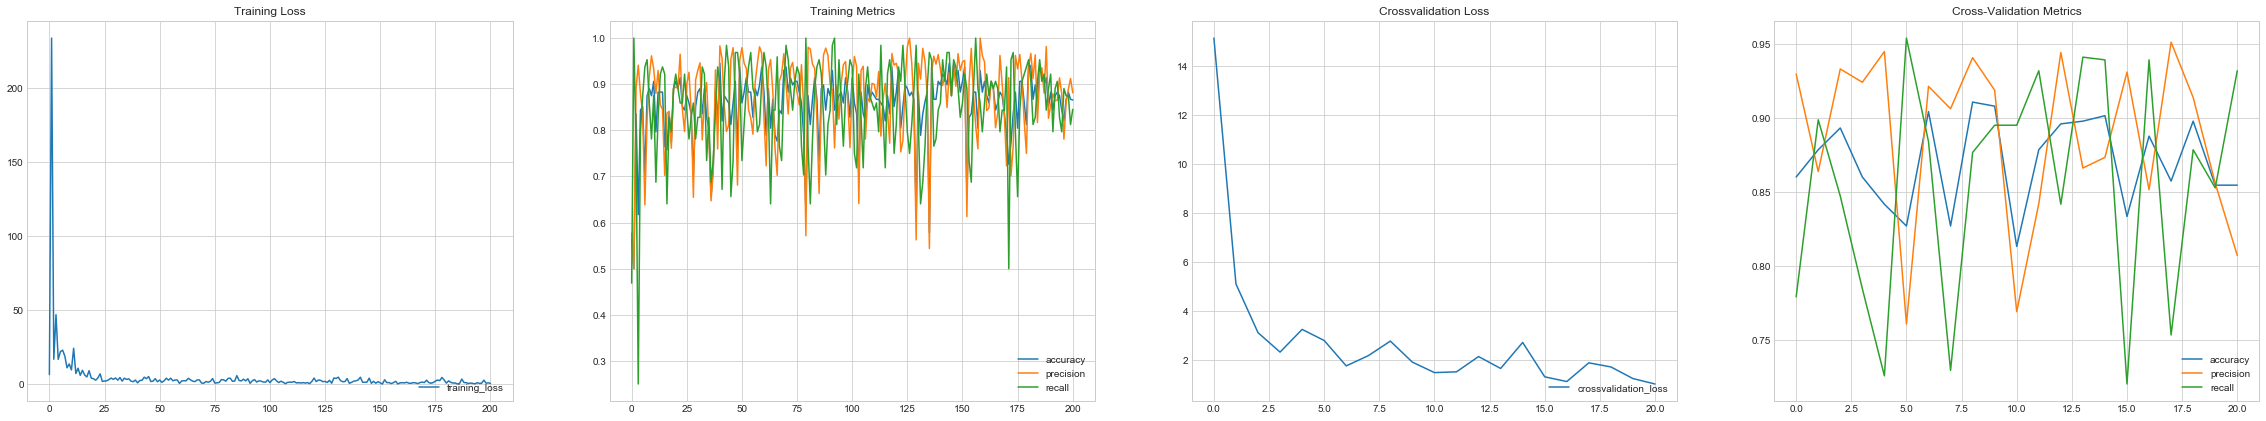

In [4]:
oj = Plot(rows=1, columns=4, fig_size=(40,7))
tr_loss_df = pd.DataFrame(tr_loss_arr, columns=['training_loss'])
oj.vizualize(data=tr_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Loss'})
tr_data = pd.DataFrame(np.column_stack((tr_acc_arr, tr_precision_arr, tr_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=tr_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Metrics'})

cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})
cv_data = pd.DataFrame(np.column_stack((cv_acc_arr, cv_precision_arr, cv_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=cv_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Cross-Validation Metrics'})

In [ ]:
## CrossValidation -Test Learning rate =0.001

In [5]:
which_data = 'cvalid'
if test:
    tsoj = Test(params=dict(inp_img_shape=[400,400,3],
                     crop_shape=[96, 96, 3],
                     out_img_shape=[224, 224, 3]),
         which_net=which_net,
         image_type=image_type)
    cv_loss_arr, cv_acc_arr, cv_precision_arr, cv_recall_arr = tsoj.run(which_data=which_data, dump_stats=True)

Dumping Checkpoints to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/checkpoint/resnet
Dumping Tensorboard Summary to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/summary/resnet
Test Graphs: RESNET
Learning Rate: Initial:  0.001
Test Graphs: RESNET
Learning Rate: Initial:  0.001
Test Graphs: RESNET
Learning Rate: Initial:  0.001
Test Graphs: RESNET
Learning Rate: Initial:  0.001
Test Graphs: RESNET
Learning Rate: Initial:  0.001
Test Graphs: RESNET
Learning Rate: Initial:  0.001
Test Graphs: RESNET
Learning Rate: Initial:  0.001
Test Graphs: RESNET
Learning Rate: Initial:  0.001
Test Graphs: RESNET
Learning Rate: Initial:  0.001
Test Graphs: RESNET
Learning Rate: Initial:  0.001


In [6]:
which_data = 'test'
if test:
    tsoj = Test(params=dict(inp_img_shape=[400,400,3],
                     crop_shape=[96, 96, 3],
                     out_img_shape=[224, 224, 3]),
         which_net=which_net,
         image_type=image_type)
    ts_loss_arr, ts_acc_arr, ts_precision_arr, ts_recall_arr = tsoj.run(which_data=which_data, dump_stats=True)

Dumping Checkpoints to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/checkpoint/resnet
Dumping Tensorboard Summary to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/summary/resnet
Test Graphs: RESNET
Learning Rate: Initial:  0.001
Test Graphs: RESNET
Learning Rate: Initial:  0.001
Test Graphs: RESNET
Learning Rate: Initial:  0.001
Test Graphs: RESNET
Learning Rate: Initial:  0.001
Test Graphs: RESNET
Learning Rate: Initial:  0.001
Test Graphs: RESNET
Learning Rate: Initial:  0.001
Test Graphs: RESNET
Learning Rate: Initial:  0.001
Test Graphs: RESNET
Learning Rate: Initial:  0.001
Test Graphs: RESNET
Learning Rate: Initial:  0.001
Test Graphs: RESNET
Learning Rate: Initial:  0.001


In [7]:
print ('Mean Values: cvalid_loss = %s, cvalid_acc = %s, cvalid_precision = %s, cvalid_recall = %s, test_loss = %s, test_acc = %s, test_precision = %s, test_recall = %s'%(
    np.mean(cv_loss_arr), np.mean(cv_acc_arr), np.mean(cv_precision_arr), np.mean(cv_recall_arr), np.mean(ts_loss_arr), np.mean(ts_acc_arr), np.mean(ts_precision_arr), np.mean(ts_recall_arr)))

Mean Values: cvalid_loss = 1.64467, cvalid_acc = 0.875875, cvalid_precision = 0.883570176016, cvalid_recall = 0.872928176796, test_loss = 1.62964, test_acc = 0.875875, test_precision = 0.889080399488, test_recall = 0.866482504604


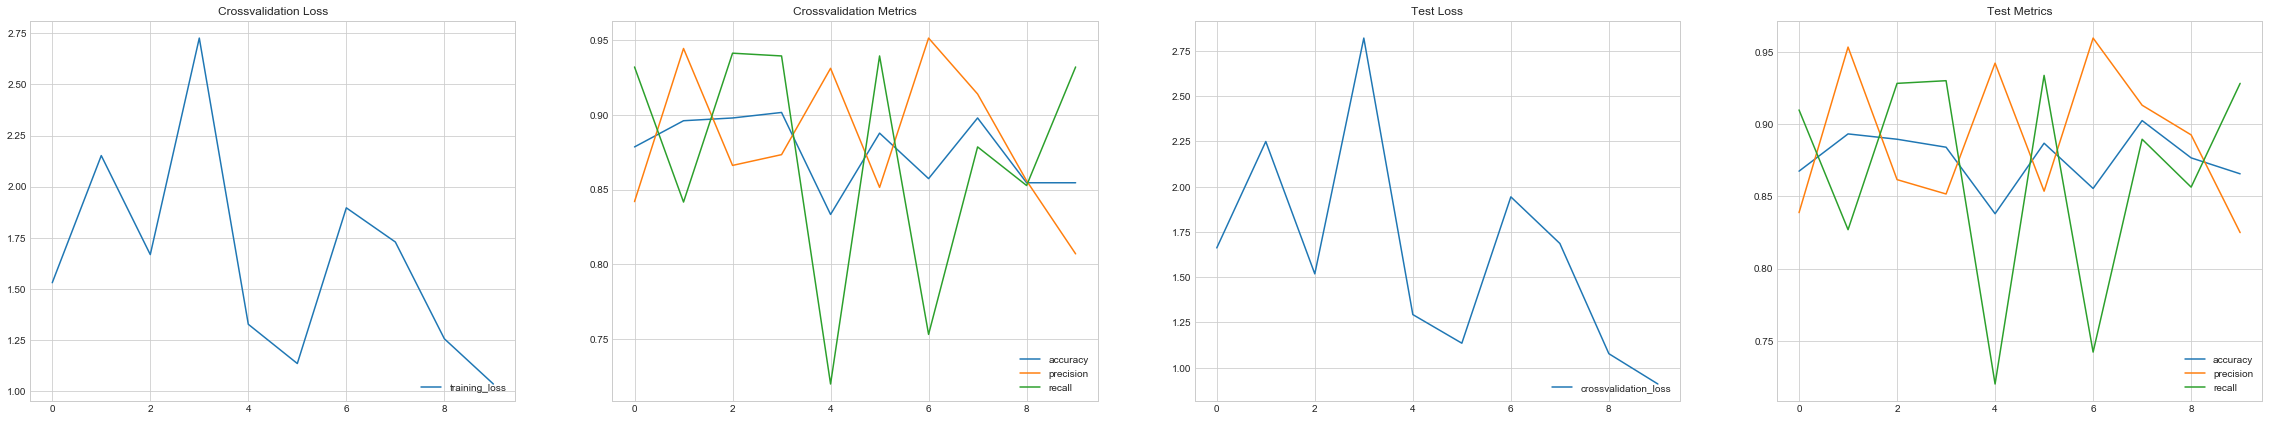

In [8]:
oj = Plot(rows=1, columns=4, fig_size=(40,7))
cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['training_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})
cv_data = pd.DataFrame(np.column_stack((cv_acc_arr, cv_precision_arr, cv_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=cv_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Metrics'})

ts_loss_df = pd.DataFrame(ts_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=ts_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Test Loss'})
ts_data = pd.DataFrame(np.column_stack((ts_acc_arr, ts_precision_arr, ts_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=ts_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Test Metrics'})

# TRAIN MODEL: Overlayed Images [Central crop: 128 x 128]
--------------

In [2]:

max_batches = 66
if train:
    tr_obj = Train(dict(inp_img_shape=[400,400,3],
                   crop_shape=[128,128,3],
                   out_img_shape=[224, 224, 3],
                   use_checkpoint=True,
                   save_checkpoint=True,
                   write_tensorboard_summary=False
                   ),
              which_net=which_net,  # vgg
              image_type=image_type)
    tr_loss_arr, tr_acc_arr, tr_precision_arr, tr_recall_arr, cv_loss_arr, cv_acc_arr, cv_precision_arr, cv_recall_arr  = tr_obj.run(num_epochs=3, num_batches=max_batches)# + 1)

Dumping Checkpoints to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/checkpoint/resnet
Dumping Tensorboard Summary to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/summary/resnet
Checkpoints not found, Hence starting at batch 0 and epoch 0........


/Users/sam/App-Setup/anaconda/envs/anaconda35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [3]:
print ('Mean Values: train_loss = %s, train_acc = %s, train_precision = %s, train_recall = %s, cv_loss = %s, cv_acc = %s, cv_precision = %s, cv_recall = %s'%(
    np.mean(tr_loss_arr), np.mean(tr_acc_arr), np.mean(tr_precision_arr), np.mean(tr_recall_arr), np.mean(cv_loss_arr), np.mean(cv_acc_arr), np.mean(cv_precision_arr), np.mean(cv_recall_arr)))

Mean Values: train_loss = 3.18681, train_acc = 0.867272, train_precision = 0.873506039712, train_recall = 0.867091119605, cv_loss = 3.70392, cv_acc = 0.849075, cv_precision = 0.845114429413, cv_recall = 0.864421643427


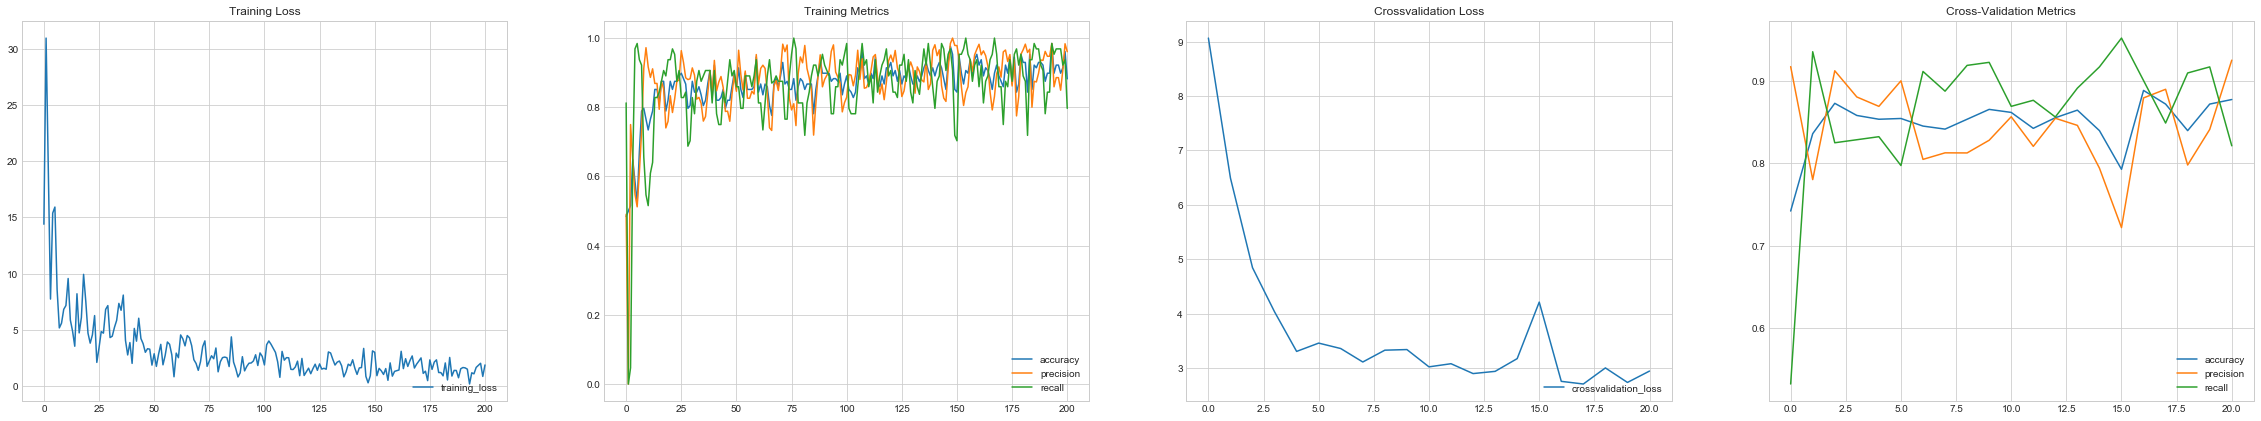

In [4]:
oj = Plot(rows=1, columns=4, fig_size=(40,7))
tr_loss_df = pd.DataFrame(tr_loss_arr, columns=['training_loss'])
oj.vizualize(data=tr_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Loss'})
tr_data = pd.DataFrame(np.column_stack((tr_acc_arr, tr_precision_arr, tr_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=tr_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Metrics'})

cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})
cv_data = pd.DataFrame(np.column_stack((cv_acc_arr, cv_precision_arr, cv_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=cv_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Cross-Validation Metrics'})

#### Cross Validation and Test

In [9]:
which_data = 'cvalid'
if test:
    tsoj = Test(params=dict(inp_img_shape=[400,400,3],
                     crop_shape=[128,128,3],
                     out_img_shape=[224, 224, 3]),
         which_net=which_net,
         image_type=image_type)
    cv_loss_arr, cv_acc_arr, cv_precision_arr, cv_recall_arr = tsoj.run(which_data=which_data, dump_stats=True)

Dumping Checkpoints to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/checkpoint/resnet
Dumping Tensorboard Summary to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/summary/resnet
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET


In [10]:
which_data = 'test'
if test:
    tsoj = Test(params=dict(inp_img_shape=[400,400,3],
                     crop_shape=[128,128,3],
                     out_img_shape=[224, 224, 3]),
         which_net=which_net,
         image_type=image_type)
    ts_loss_arr, ts_acc_arr, ts_precision_arr, ts_recall_arr = tsoj.run(which_data=which_data, dump_stats=True)

Dumping Checkpoints to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/checkpoint/resnet
Dumping Tensorboard Summary to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/overlayed_images/google/summary/resnet
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET
Test Graphs: RESNET


In [11]:
print ('Mean Values: cvalid_loss = %s, cvalid_acc = %s, cvalid_precision = %s, cvalid_recall = %s, test_loss = %s, test_acc = %s, test_precision = %s, test_recall = %s'%(
    np.mean(cv_loss_arr), np.mean(cv_acc_arr), np.mean(cv_precision_arr), np.mean(cv_recall_arr), np.mean(ts_loss_arr), np.mean(ts_acc_arr), np.mean(ts_precision_arr), np.mean(ts_recall_arr)))

Mean Values: cvalid_loss = 3.04346, cvalid_acc = 0.854512, cvalid_precision = 0.837199492712, cvalid_recall = 0.889134438306, test_loss = 2.91016, test_acc = 0.850184, test_precision = 0.830518981247, test_recall = 0.888397790055


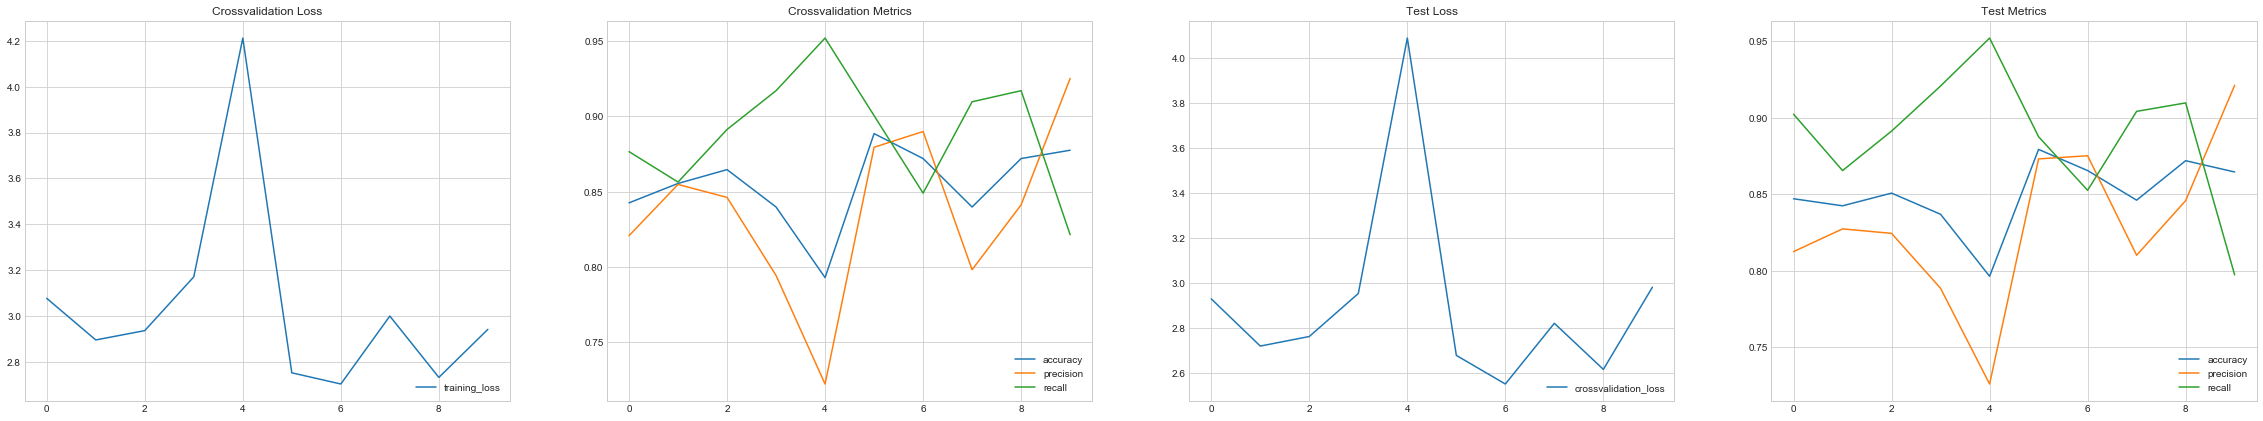

In [12]:
oj = Plot(rows=1, columns=4, fig_size=(40,7))
cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['training_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})
cv_data = pd.DataFrame(np.column_stack((cv_acc_arr, cv_precision_arr, cv_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=cv_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Metrics'})

ts_loss_df = pd.DataFrame(ts_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=ts_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Test Loss'})
ts_data = pd.DataFrame(np.column_stack((ts_acc_arr, ts_precision_arr, ts_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=ts_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Test Metrics'})